In [1]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import numpy as np
import pickle as pkl
from schnetpack.nn import build_mlp
from sklearn.metrics import r2_score, root_mean_squared_error

from typing import Sequence, Union, Callable, Dict, Optional

import torch
import torch.nn as nn
import torch.nn.functional as F

import schnetpack as spk
import schnetpack.nn as snn
import schnetpack.properties as properties

# from torch.optim.lr_scheduler import StepLR

In [2]:
device = torch.device("cuda:1")

### Load Data

In [52]:
!pwd

/home/maligina/yana/gnn


In [53]:
!ls ../data/

conformers_1_chromophore_train.db  train_clean.csv
test_clean.csv			   train_clean_scalar_painn_test.pkl
test_clean_scalar_painn.pkl	   train_clean_scalar_painn_train.pkl


### Target: Absorption_max_nm

In [3]:
train_data = pd.read_pickle('/home/propad/gnn/DimeNet/embeddings_DimeNet/train_clean_scalar_dimenet_train.pkl')
test_data = pd.read_pickle('/home/propad/gnn/DimeNet/embeddings_DimeNet/train_clean_scalar_dimenet_test.pkl')
test_eval = pd.read_pickle('/home/propad/gnn/DimeNet/embeddings_DimeNet/test_clean_scalar_dimenet.pkl')

train_target_log = torch.FloatTensor(np.log(train_data['Quantum_yield'].to_numpy() + 1e-8))
test_target_log = torch.FloatTensor(np.log(test_data['Quantum_yield'].to_numpy() + 1e-8))
test_eval_target_log = torch.FloatTensor(np.log(test_eval['Quantum_yield'].to_numpy() + 1e-8))

train_tensor = torch.stack(train_data['Concatenated_embedding'].to_list(), dim=0)
# train_target = torch.FloatTensor(train_data['Quantum_yield'].to_list())
# train_target_norm = (train_target - train_target.mean()) / train_target.std()
train_dataset = TensorDataset(train_tensor, train_target_log)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_tensor = torch.stack(test_data['Concatenated_embedding'].to_list(), dim=0)
# test_target = torch.FloatTensor(test_data['Quantum_yield'].to_list())
# test_target_norm = (test_target - test_target.mean()) / test_target.std()
test_dataset = TensorDataset(test_tensor, test_target_log)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

test_eval_tensor = torch.stack(test_eval['Concatenated_embedding'].to_list(), dim=0)
# test_eval_target = torch.FloatTensor(test_eval['Quantum_yield'].to_list())
# test_eval_target_norm = (test_eval_target - test_eval_target.mean()) / test_eval_target.std()
test_eval_dataset = TensorDataset(test_eval_tensor, test_eval_target_log)
test_eval_loader = DataLoader(test_eval_dataset, batch_size=32, shuffle=True)

In [4]:
for i, batch in enumerate(test_loader):
    inputs, labels = batch
    
    # Check for NaN values in inputs and labels
    if torch.isnan(inputs).any():
        print(f"NaN detected in inputs at batch {i}")
        
    if torch.isnan(labels).any():
        print(f"NaN detected in labels at batch {i}")

NaN detected in inputs at batch 4
NaN detected in inputs at batch 5
NaN detected in inputs at batch 6
NaN detected in inputs at batch 8
NaN detected in inputs at batch 14
NaN detected in inputs at batch 16
NaN detected in inputs at batch 19
NaN detected in inputs at batch 20
NaN detected in inputs at batch 21
NaN detected in inputs at batch 22
NaN detected in inputs at batch 23
NaN detected in inputs at batch 26
NaN detected in inputs at batch 28
NaN detected in inputs at batch 30
NaN detected in inputs at batch 31


In [56]:
class MLPModel(nn.Module):
    def __init__(self, n_in, n_out, n_hidden, n_layers, activation):
        super().__init__()
        self.mlp = spk.nn.build_mlp(
            n_in=n_in,
            n_out=n_out,
            n_hidden=n_hidden,
            n_layers=n_layers,
            activation=activation,
        )

    def forward(self, emb):
        return self.mlp(emb)

In [57]:
model = MLPModel(256, 1, [512, 256, 128], n_layers=4, activation=F.silu)
model.to(device)

MLPModel(
  (mlp): Sequential(
    (0): Dense(in_features=256, out_features=512, bias=True)
    (1): Dense(in_features=512, out_features=256, bias=True)
    (2): Dense(in_features=256, out_features=128, bias=True)
    (3): Dense(
      in_features=128, out_features=1, bias=True
      (activation): Identity()
    )
  )
)

In [58]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
# scheduler = StepLR(optimizer, step_size=10, gamma=0.5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

In [59]:
def train_one_epoch(epoch_index):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(train_loader):
        # Every data instance is an input + label pair
        inputs, labels = data

        inputs = inputs.to(device)
        labels = labels.to(device)

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs.squeeze(1), labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 100 == 99:
            last_loss = running_loss / 100 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            running_loss = 0.

    return last_loss

In [60]:
# Initializing in a separate cell so we can easily add more epochs to the same run
epoch_number = 0
EPOCHS = 500

train_loss_values = []
val_loss_values = []

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number)
    train_loss_values.append(avg_loss)
    
    running_vloss = 0.0
    model.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, vdata in enumerate(test_loader):
            vinputs, vlabels = vdata
            vinputs = vinputs.to("cuda:1")
            vlabels = vlabels.to("cuda:1")
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs.squeeze(1), vlabels).item()
            running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    val_loss_values.append(avg_vloss)
    
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))
    
    # scheduler.step()
    scheduler.step(avg_vloss)

    epoch_number += 1

EPOCH 1:
  batch 100 loss: 5.030104764699936
  batch 200 loss: 3.101677006483078
LOSS train 3.101677006483078 valid 3.4968782290816307
EPOCH 2:
  batch 100 loss: 2.9548147308826445
  batch 200 loss: 2.9960317468643187
LOSS train 2.9960317468643187 valid 3.5835913717746735
EPOCH 3:
  batch 100 loss: 2.9236416530609133
  batch 200 loss: 2.850365616083145
LOSS train 2.850365616083145 valid 3.3583860248327255
EPOCH 4:
  batch 100 loss: 2.7675919771194457
  batch 200 loss: 2.7442680168151856
LOSS train 2.7442680168151856 valid 3.1529356874525547
EPOCH 5:
  batch 100 loss: 2.652113072872162
  batch 200 loss: 2.715234125852585
LOSS train 2.715234125852585 valid 3.019937474280596
EPOCH 6:
  batch 100 loss: 2.525844393968582
  batch 200 loss: 2.680077325105667
LOSS train 2.680077325105667 valid 2.872957222163677
EPOCH 7:
  batch 100 loss: 2.5886574637889863
  batch 200 loss: 2.4506946337223052
LOSS train 2.4506946337223052 valid 2.962350271642208
EPOCH 8:
  batch 100 loss: 2.516972620487213
  b

LOSS train 2.006165207028389 valid 3.2497046440839767
EPOCH 24:
  batch 100 loss: 1.9236564546823502
  batch 200 loss: 1.9558195996284484
LOSS train 1.9558195996284484 valid 2.306155990809202
EPOCH 25:
  batch 100 loss: 1.7678364706039429
  batch 200 loss: 1.9628013616800308
LOSS train 1.9628013616800308 valid 3.34450376778841
EPOCH 26:
  batch 100 loss: 1.9352432298660278
  batch 200 loss: 1.8931133562326432
LOSS train 1.8931133562326432 valid 2.390801567584276
EPOCH 27:
  batch 100 loss: 1.7520808047056198
  batch 200 loss: 1.8424766558408736
LOSS train 1.8424766558408736 valid 2.235000103712082
EPOCH 28:
  batch 100 loss: 1.79238542675972
  batch 200 loss: 1.7442343705892562
LOSS train 1.7442343705892562 valid 2.255708072334528
EPOCH 29:
  batch 100 loss: 1.7321607428789139
  batch 200 loss: 1.7144927549362183
LOSS train 1.7144927549362183 valid 2.229382835328579
EPOCH 30:
  batch 100 loss: 1.8508217525482178
  batch 200 loss: 1.6834259235858917
LOSS train 1.6834259235858917 valid 2

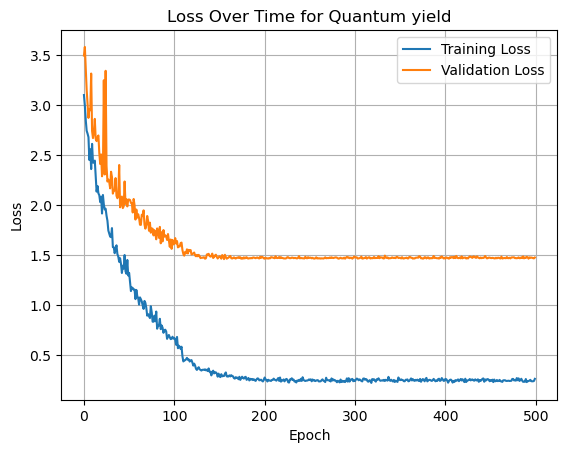

In [61]:
import matplotlib.pyplot as plt

# Plotting the training and validation loss values
plt.plot(train_loss_values, label='Training Loss')
plt.plot([val for val in val_loss_values], label='Validation Loss')
plt.xlabel('Epoch')

plt.ylabel('Loss')
plt.title('Loss Over Time for Quantum yield')
plt.legend()
plt.grid(True)
plt.show()

In [62]:
# After training, evaluate the model on test data
model.eval()  # Set the model to evaluation mode
running_test_loss = 0.0

# Lists to store actual and predicted values
actual_values = []
predicted_values = []

with torch.no_grad():  # Disable gradient calculation
    for i, data in enumerate(test_eval_loader):
        inputs, labels = data
        inputs = inputs.to("cuda:1")
        labels = labels.to("cuda:1")
        
        # Forward pass through the model
        outputs = model(inputs)
        loss = loss_fn(outputs.squeeze(1), labels)
                
        # Append actual and predicted values to lists
        actual_values.extend(labels.cpu().numpy())
        predicted_values.extend(outputs.squeeze(1).cpu().numpy())

        running_test_loss += loss.item()

# Calculate the average loss over the test dataset
avg_test_loss = running_test_loss / (i + 1)

# actual_values_unscaled = [i * std_train.item() + mean_train.item() for i in actual_values]
# predicted_values_unscaled = [i * std_train.item() + mean_train.item() for i in predicted_values]

# Unscale actual and predicted values after logarithmic transformation
actual_values_unscaled = [np.exp(i) for i in actual_values]
predicted_values_unscaled = [np.exp(i) for i in predicted_values]

# Compute R^2 and RMSE
r2 = np.corrcoef(actual_values, predicted_values)[0,1] **2
rmse = root_mean_squared_error(actual_values, predicted_values)

print(f"R^2: {r2:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"Average test loss: {avg_test_loss}")


R^2: 0.578
RMSE: 1.185
Average test loss: 1.3806560933589935
